In [1]:
import cv2
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

2021-12-21 09:37:28.741773: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/lucky/.venvs/bct-major-project-JO5e2uOw/lib/python3.9/site-packages/cv2/../../lib64:
2021-12-21 09:37:28.741807: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
image_size = (128, 128)
batch_size = 32

In [3]:
train_df = pd.read_csv("../dataset/new_merged/train_merged.csv")

In [4]:
val_df = pd.read_csv("../dataset/new_merged/val_merged.csv")

In [5]:
test_df = pd.read_csv("../dataset/new_merged/test_merged.csv")

In [6]:
from pathlib import Path

def get_images_paths(partition, filenames):
    images_base_path = Path("../dataset/images/")
    image_names = filenames.split(";")
    images_path = []
    
    for image_name in image_names:
        p = list(image_name[:4])
        image_path = images_base_path / partition / p[0] / p[1] / p[2] / p[3] / image_name
        images_path.append(image_path)
    
    return images_path

In [7]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def get_image(image_path, image_size):
    resized_image = load_img(image_path, target_size=image_size)
    image = img_to_array(resized_image) / 255
    return image

(128, 128, 3)


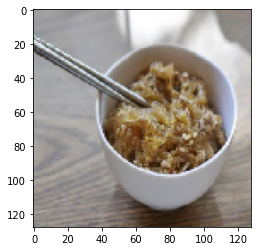

In [8]:
t = get_images_paths("test", "89c648b622.jpg")[0]
plt_img = get_image(str(t), image_size)
print(plt_img.shape)
plt.imshow(plt_img)

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

ingr_tokenizer = Tokenizer(split=";")
ingr_tokenizer.fit_on_texts(train_df["ingredients"])
total_ingr = len(ingr_tokenizer.word_index)
# ingr_tokenizer.word_index

In [10]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, df, batch_size, image_size, image_channels, partition, shuffle=True):
        self.df = df
        self.batch_size = batch_size
        self.image_size = image_size
        self.image_channels = image_channels
        self.partition = partition
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def __getitem__(self, index):
        
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_df = self.df.iloc[indexes]
        
        X_images = np.empty((self.batch_size, *self.image_size, self.image_channels))
        Y_labels = np.empty((self.batch_size, total_ingr + 1))
        
        for i, row in enumerate(batch_df.iterrows()):
            (row_index, row_value) = row
            images_path = get_images_paths(self.partition, row_value["image_file_names"])
            
#             only take first image path for now
            image = get_image(str(images_path[0]), self.image_size)
            target = ingr_tokenizer.texts_to_matrix([row_value["ingredients"].split(";")], mode="binary")
            
            X_images[i,] = image
            Y_labels[i] = target
        
        return X_images, Y_labels
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

In [11]:
# test_generator = DataGenerator(test_df, 32, (128, 128), 3, "test")
# test = iter(test_generator)
# next(test)

In [12]:
train_generator = DataGenerator(
    df=train_df, 
    batch_size=batch_size,
    image_size=image_size,
    image_channels=3,
    partition="train"
)

val_generator = DataGenerator(
    df=val_df, 
    batch_size=batch_size,
    image_size=image_size,
    image_channels=3,
    partition="val"
)

test_generator = DataGenerator(
    df=test_df, 
    batch_size=batch_size,
    image_size=image_size,
    image_channels=3,
    partition="test"
)

In [15]:
import tensorflow_hub as hub

hub_url = 'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b0/feature-vector'

efn_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[*image_size, 3]),
    hub.KerasLayer(hub_url, trainable=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(total_ingr+1, activation='sigmoid'),
])

2021-12-21 09:42:19.121870: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 68684800 exceeds 10% of free system memory.
2021-12-21 09:42:19.178655: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 68684800 exceeds 10% of free system memory.


In [16]:
efn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              5919312   
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 13415)             17184615  
                                                                 
Total params: 23,103,927
Trainable params: 17,184,615
Non-trainable params: 5,919,312
_________________________________________________________________


In [13]:
from tensorflow.keras.applications.resnet50 import ResNet50

base_model = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(*image_size, 3))

base_model.trainable = False

2021-12-09 15:06:03.670325: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/lucky/.venvs/bct-major-project-JO5e2uOw/lib/python3.9/site-packages/cv2/../../lib64:
2021-12-09 15:06:03.670427: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-09 15:06:03.670470: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lord): /proc/driver/nvidia/version does not exist
2021-12-09 15:06:03.670971: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
total_ingr

13414

In [15]:
from tensorflow.keras import models, layers

flatten = layers.Flatten()(base_model.output)
dense = layers.Dense(2048, activation='relu')(flatten)
output = layers.Dense(total_ingr + 1, activation='sigmoid')(dense)

model = models.Model(inputs=base_model.input, outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']         

In [17]:
# model.compile(optimizer="adam", loss="binary_crossentropy")
efn_model.compile(optimizer="adam", loss="binary_crossentropy")

In [17]:
history = model.fit(
    x=test_generator,
    batch_size=batch_size, 
    epochs=3,
#     validation_data=val_generator,
    use_multiprocessing=True,
    workers=6
)

Epoch 1/3
275/275 [==============================] - 550s 2s/step - loss: 0.0108
Epoch 2/3
275/275 [==============================] - 536s 2s/step - loss: 0.0036
Epoch 3/3
275/275 [==============================] - 546s 2s/step - loss: 0.0035


In [18]:
efn_history = efn_model.fit(
    x=test_generator,
    batch_size=batch_size, 
    epochs=3,
    use_multiprocessing=True,
    workers=6
)

Epoch 1/3
 35/275 [==>...........................] - ETA: 7:05 - loss: 0.2726

Process Keras_worker_ForkPoolWorker-2:
Process Keras_worker_ForkPoolWorker-6:
Process Keras_worker_ForkPoolWorker-3:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Process Keras_worker_ForkPoolWorker-5:
Process Keras_worker_ForkPoolWorker-1:
Process Keras_worker_ForkPoolWorker-4:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/pool.py", line

KeyboardInterrupt: 

In [ ]:
a = iter(val_generator)

In [134]:
x, y = next(a)

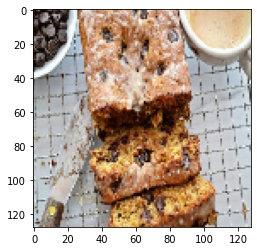

In [135]:
plt.imshow(x[0])

In [136]:
tada = dict(map(reversed, ingr_tokenizer.word_index.items()))

In [137]:
yas =[i+1 for i, x in enumerate(y[0]) if x == 1]
[tada[i] for i in yas]

['garlic cloves',
 'brown sugar',
 'vanilla extract',
 'pepper',
 'soy sauce',
 'honey',
 'extra virgin olive oil',
 'nutmeg',
 'whole milk',
 'garlic salt',
 'rice vinegar',
 'sherry wine',
 'boiling potatoes',
 'powdered cocoa mix']

In [138]:
pred = model.predict(x[0].reshape(-1, 128, 128, 3))

In [144]:
[i for i in pred[0]]

[3.1802654e-05,
 0.41305822,
 0.2811213,
 0.138123,
 0.09865892,
 0.20315713,
 0.14512318,
 0.1394589,
 0.14848277,
 2.5421119e-05,
 2.7706275e-05,
 0.07479808,
 0.08992982,
 0.13730296,
 0.06366849,
 0.098970085,
 0.0633848,
 0.06298953,
 0.03981942,
 0.09593055,
 0.074925005,
 0.09950265,
 0.1062116,
 0.057783157,
 0.031226337,
 0.05606976,
 0.04089299,
 0.036416143,
 0.058842868,
 0.0661141,
 0.06609252,
 0.043916583,
 0.043818146,
 0.022559434,
 0.035113633,
 0.05271846,
 0.02022025,
 0.040851265,
 0.040619582,
 0.037504435,
 0.033025026,
 0.019296795,
 0.039325625,
 0.03661591,
 0.032573283,
 0.014457673,
 2.9118673e-05,
 0.022748709,
 0.016269207,
 0.03323874,
 0.016487092,
 0.022702366,
 0.03677365,
 0.064736694,
 0.019099087,
 0.0062130988,
 0.022970617,
 0.017102003,
 0.015435457,
 0.019860893,
 0.024119377,
 0.029286295,
 0.014282256,
 0.024285406,
 0.011347175,
 0.017514616,
 0.02331698,
 0.017729849,
 0.01866576,
 0.03219837,
 0.018228948,
 0.017145783,
 0.01310721,
 0.0147

In [139]:
iasd =[i+1 for i, x in enumerate(pred[0]) if x > 0.1] 

In [140]:
# ingr_tokenizer.([prpedlist])
# dict(map(reversed, ingr_tokenizer.word_index.items()))


[tada[i] for i in iasd]

['butter',
 'sugar',
 'olive oil',
 'eggs',
 'garlic cloves',
 'milk',
 ' purpose flour',
 'baking powder',
 'parmesan cheese']

In [18]:
# from wordcloud import WordCloud

# w = WordCloud(width= 3000, height = 2000).generate(" ".join(seq))
# plt.figure(figsize=(40, 30))
# plt.imshow(w)
# plt.axis("off");